Instalando o GEOPANDAS e outras bibliotecas

executar os códigos no terminal!

<code>conda create --yes --name workshop1 python=3.7</code>

<code>conda activate workshop1</code>

<code>conda install jupyterlab=2.2.6</code>

<code>conda install -c conda-forge pyproj=2.4.2.post1</code>

<code>conda install -c conda-forge descartes=1.1.0</code>

<code>conda install -c conda-forge geopandas=0.8.1</code>

<code>conda install -c conda-forge geopy=2.0.0</code>

<code>conda install pandas</code>

<code>conda install numpy</code>

<code>conda install matplotlib</code>

In [22]:
# importando bibliotecas que serao utilizadas
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import descartes
import pyproj
import shapely.wkt
import seaborn as sns

In [2]:
# lendo o conjunto de dados
df = pd.read_csv('Real_State_Properati.csv', sep = '\t')

In [3]:
# checando as primeiras linhas do conjunto
df.head()

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2
0,PH,Mataderos,Argentina,Capital Federal,-34.661824,-58.508839,62000.0,USD,55.0
1,apartment,Mataderos,Argentina,Capital Federal,-34.652262,-58.522982,72000.0,USD,55.0
2,apartment,Belgrano,Argentina,Capital Federal,-34.559873,-58.443362,138000.0,USD,45.0
3,apartment,Belgrano,Argentina,Capital Federal,-34.559873,-58.443362,195000.0,USD,65.0
4,PH,Mataderos,Argentina,Capital Federal,-34.652356,-58.501624,239000.0,USD,140.0


property_type : Tipo de propriedade.

place_name : Nome do bairro.

country_name : Nome do pais.

state_name: Localidade da propriedade.

lat : Latitude

lon : Longitude

price : Preco publicado na propaganda.

currency : tipo de moeda utilizada no anuncio.

surface_total_in_m2 : metragem da area do imovel.

In [4]:
# informação das colunas para ver se existem campos nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17223 entries, 0 to 17222
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_type        17223 non-null  object 
 1   place_name           17223 non-null  object 
 2   country_name         17223 non-null  object 
 3   state_name           17223 non-null  object 
 4   lat                  17223 non-null  float64
 5   lon                  17223 non-null  float64
 6   price                17223 non-null  float64
 7   currency             17223 non-null  object 
 8   surface_total_in_m2  17223 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.2+ MB


In [5]:
# checando por se existem nomes de bairros que podem ser unificados

df['place_name'].unique()

#Palermo = Palermo Hollywood = Palermo Chico = Palermo Viejo = Las Cañitas

array(['Mataderos', 'Belgrano', 'Palermo', 'Flores', 'Boedo',
       'Las Cañitas', 'Puerto Madero', 'Balvanera', 'Caballito', 'Nuñez',
       'Floresta', 'Barracas', 'Recoleta', 'Congreso', 'Villa Crespo',
       'Chacarita', 'Almagro', 'Constitución', 'Colegiales',
       'Villa Urquiza', 'Barrio Norte', 'Palermo Hollywood', 'Saavedra',
       'Paternal', 'Agronomía', 'Villa Pueyrredón', 'Coghlan',
       'Parque Centenario', 'San Telmo', 'Monserrat', 'Boca',
       'Parque Avellaneda', 'San Cristobal', 'Abasto', 'Versalles',
       'Villa del Parque', 'Monte Castro', 'Retiro', 'Capital Federal',
       'Parque Chas', 'Palermo Chico', 'Villa Devoto', 'Palermo Soho',
       'Centro / Microcentro', 'Liniers', 'Tribunales', 'Once',
       'San Nicolás', 'Parque Chacabuco', 'Velez Sarsfield', 'Catalinas',
       'Pompeya', 'Parque Patricios', 'Palermo Viejo', 'Villa Lugano',
       'Villa Luro', 'Villa General Mitre', 'Villa Ortuzar',
       'Villa Santa Rita', 'Villa Soldati', 'Villa Re

In [6]:
# convertendo preços com moeda ARS para USD

#1 ARS =  0.0085 USD

df['price_ajustado'] = df['price']

df['currency_ajustado'] = df['currency']

df.loc[df['currency']=='ARS', 'price_ajustado'] = df['price'] * 0.0085

df.loc[df['currency']=='ARS', 'currency_ajustado'] = df['currency'] = 'USD'

df.head()

In [8]:
# criando o campo da geometria

df['geo'] = gpd.points_from_xy(df['lon'], df['lat'])
df.head()

In [19]:
# criando um subset dos dados para realizar analise exploratoria

df_ajustado = df[['property_type', 'place_name', 'country_name', 'state_name', 'surface_total_in_m2', 'price_ajustado', 'currency_ajustado', 'geo']]

In [47]:
df_ajustado.head()

,property_type,place_name,country_name,state_name,surface_total_in_m2,price_ajustado,currency_ajustado,geo
0,PH,Mataderos,Argentina,Capital Federal,55.0,62000.0,USD,POINT (-58.50884 -34.66182)
1,apartment,Mataderos,Argentina,Capital Federal,55.0,72000.0,USD,POINT (-58.52298 -34.65226)
2,apartment,Belgrano,Argentina,Capital Federal,45.0,138000.0,USD,POINT (-58.44336 -34.55987)
3,apartment,Belgrano,Argentina,Capital Federal,65.0,195000.0,USD,POINT (-58.44336 -34.55987)
4,PH,Mataderos,Argentina,Capital Federal,140.0,239000.0,USD,POINT (-58.50162 -34.65236)


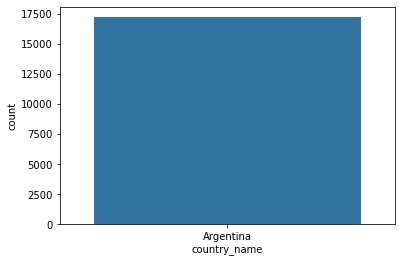

In [31]:
# todos os dados estão concentrados na argentina
sns.countplot(data=df_ajustado, x='country_name')
plt.show()

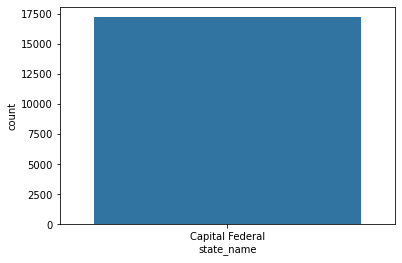

In [32]:
# todos os dados estão concentrados nas capital da argentina
sns.countplot(data=df_ajustado, x='state_name')
plt.show()

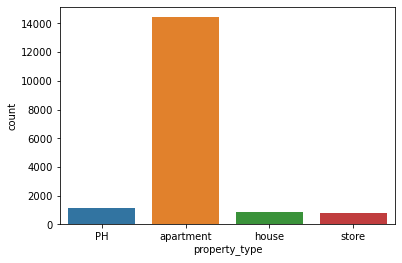

In [33]:
# grande parte dos imoveis estão concentrados em apartamentos
sns.countplot(data = df_ajustado, x = 'property_type')
plt.show()

<AxesSubplot:xlabel='property_type', ylabel='surface_total_in_m2'>

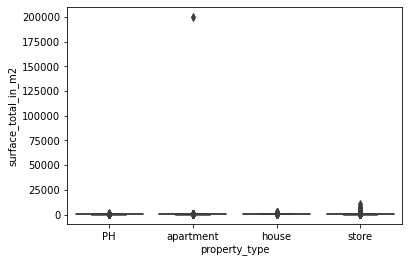

In [44]:
# distribuição do preço
sns.boxplot(data= df_ajustado, x = 'property_type',y='surface_total_in_m2')